### 190648C
### VIKASITHA K.S.S.
#### ASSIGNMENT 01

$Q1$

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import random
#np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1) , y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))
# fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(X[:,0], X[:,1])
# # ax.axis('off')
# plt.show()

$Q1$ $(a)$

In [3]:
def circleEstimate(min_iterations, min_inliers, no_of_points, points, inlier_treshold):
    its = min_iterations
    max_inliers = 0
    while max_inliers < min_inliers or its > 0:
        # Randomly choose 3 points
        sample = random.sample(range(1, no_of_points), 3)
        x1 = np.zeros([3,2])
        for i in range(3):
            x1[i]=points[sample[i]]
        
        # Calculate the coordinates of the center & the radius of the circle passing through those 3 points
        x2 = np.hstack((x1,np.ones((3,1))))
        x3 = (-1*((x1[:,0]*x1[:,0])+(x1[:,1]*x1[:,1]))).reshape(3,1)
        c = np.matmul(np.linalg.inv(x2),x3)
        c_x , c_y = -c[0]/2 , -c[1]/2
        radius = np.sqrt(c_x*c_x + c_y*c_y - c[2])

        if radius > 30:continue
        
        no_of_inliers, inlier_points = inlierCount(points, c_x, c_y, radius, inlier_treshold) # Find inliers
        
        # Check whether it is the best model with most inliers
        if max_inliers < no_of_inliers:
            max_inliers, circle_parameters, best_inlier_points, best_sample = no_of_inliers, [c_x,c_y,radius], inlier_points, x1
        if max_inliers >= min_inliers:
            its-=1
    
    return max_inliers, circle_parameters, best_inlier_points, best_sample

# Check whether a given point is an inlier or not
def isInlier(x, y, cx, cy, r, T):
    r_=(x-cx)**2+(y-cy)**2
    if r-T < np.sqrt(r_) < r+T:
        return True
    else: return False

# Find inliers of a given circle
def inlierCount(points, cx, cy, r, T):
    n=0
    inlier_arr=np.zeros((1,2))
    for i in points:
        if isInlier(i[0], i[1], cx, cy, r, T):
            n+=1
            if not inlier_arr.any():
                inlier_arr[0]=i
            else:
                inlier_arr=np.concatenate((inlier_arr,[i]),axis=0)
    return n,inlier_arr

$Q1$ $(b)$

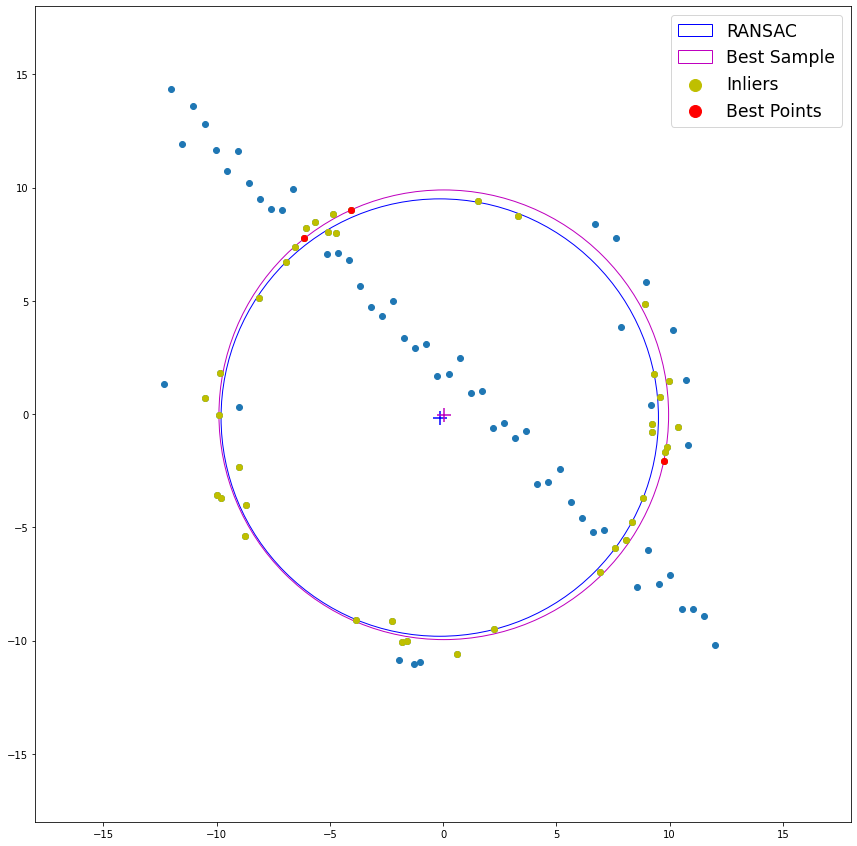

In [4]:
m1,circ,inls,bestpoints=circleEstimate(200,42,N,X,0.9)
figure, axes = plt.subplots(figsize=(15,15))
draw_circle = plt.Circle((circ[0], circ[1]), circ[2],fill=False,color='b',label='RANSAC')
axes.scatter(circ[0], circ[1],color='b',marker='+',s=180)
axes.set_aspect(1)
axes.add_artist(draw_circle)

m,circ,inls,bestpoints=circleEstimate(200,30,m1,inls,0.75)
draw_circle = plt.Circle((circ[0], circ[1]), circ[2],fill=False,color='m',label='Best Sample')
axes.add_artist(draw_circle)
axes.scatter(X[:,0], X[:,1])
axes.scatter(inls[:,0], inls[:,1],color='y',label='Inliers')
axes.scatter(bestpoints[:,0], bestpoints[:,1],color='r',label='Best Points')
axes.scatter(circ[0], circ[1],marker='+',c='m',s=180)
plt.xlim(-18,18)
plt.ylim(-18,18)
plt.legend(fontsize='xx-large',markerscale=2.0)
plt.show()

$Q2$

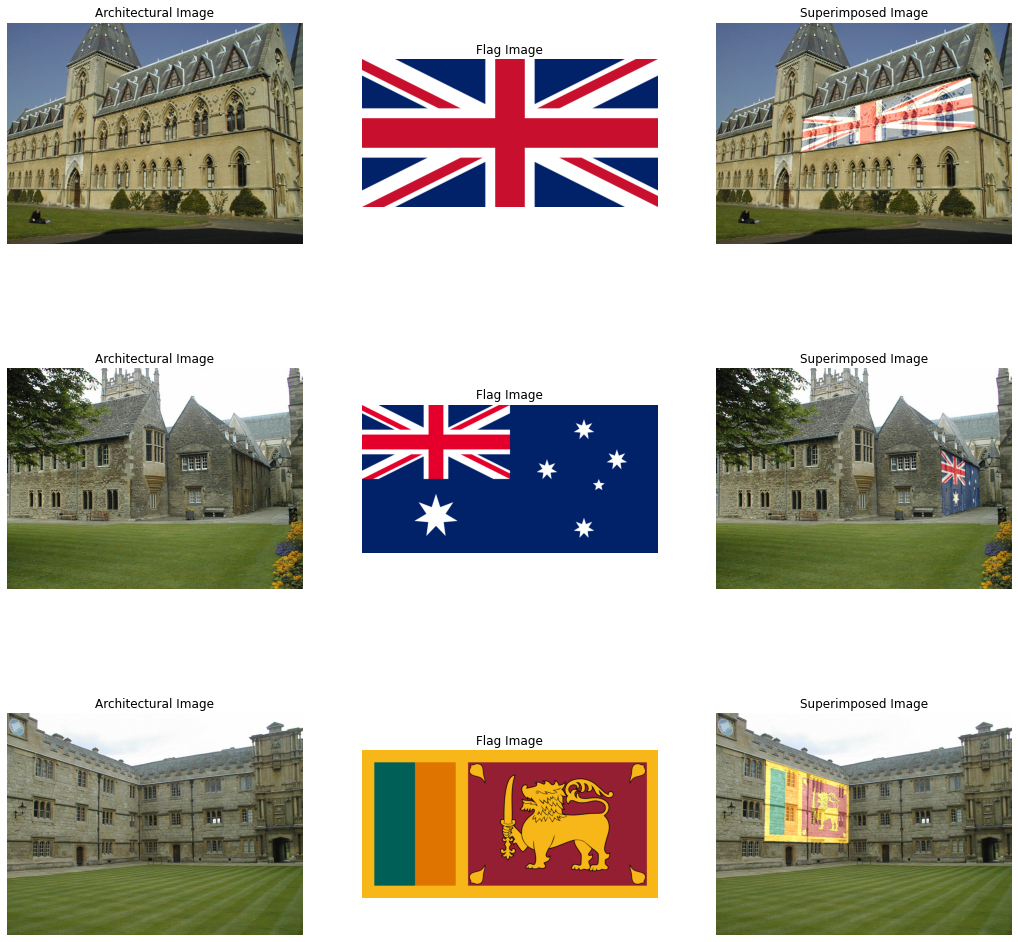

In [20]:
import cv2 as cv

point_matrix = np.zeros((4,2),dtype=np.float32)
 
counter = 0
def mouseClicks(event,x,y,flags,params):
    global counter
    if event == cv.EVENT_LBUTTONDOWN:
        point_matrix[counter] = x,y
        counter = counter + 1
    if counter==4:counter=0

def gettingPoints(im, win_name):
    cv.imshow(win_name,im)
    cv.setMouseCallback(win_name,mouseClicks)
    cv.waitKey(0)
    cv.destroyAllWindows()

def BGR2RGB(im):
    return cv.cvtColor(im,cv.COLOR_BGR2RGB)

fig , ax = plt.subplots(3 , 3 ,figsize=(18,18))

for j in range(1,4):
    img = cv.imread(r'Assignment-02 Materials\im{}.jpg'.format(j))
    assert img is not None
    flag = cv.imread(r'Assignment-02 Materials\f{}.png'.format(j))
    assert flag is not None

    gettingPoints(img, 'img{}'.format(j))
    H = cv.getPerspectiveTransform(np.array([[0, 0],[np.shape(flag)[1],0],[0,np.shape(flag)[0]],[np.shape(flag)[1],np.shape(flag)[0]]],dtype=np.float32), point_matrix)
    warped_f = cv.warpPerspective(flag, H,(np.shape(img)[1],np.shape(img)[0]))
    result = cv.addWeighted(img, 1, warped_f, 0.6, 0)

    titles = ("Architectural Image" , "Flag Image", "Superimposed Image")

    ax[j-1,0].imshow(BGR2RGB(img))
    ax[j-1,1].imshow(BGR2RGB(flag))
    ax[j-1,2].imshow(BGR2RGB(result))
    for k in range(3):
        ax[j-1,k].axis('off')
        ax[j-1,k].set_title(titles[k])
plt.show()

$Q3$

In [83]:
def isSiftInlier(p1,p2,H,T):
    P = np.matmul(H,np.append(p1,1))
    P=P/P[-1]
    P = P[:2]-p2
    dis = np.sqrt(P[0]**2 + P[1]**2)
    if dis <= T:
        return True
    else:return False

def siftInlierCount(points1, points2, H, T):
    count=0
    l=points1.shape[0]
    inlier_arr1 = np.zeros((1,2))
    inlier_arr2 = np.zeros((1,2))
    for i in range(l):
        if isSiftInlier(points1[i],points2[i],H,T):
            count+=1
            if not inlier_arr1.any():
                inlier_arr1[0] = points1[i]
                inlier_arr2[0] = points2[i]
            else:
                inlier_arr1 = np.concatenate((inlier_arr1, [points1[i]]), axis=0)
                inlier_arr2 = np.concatenate((inlier_arr2, [points2[i]]), axis=0)
    return count,inlier_arr1,inlier_arr2

94


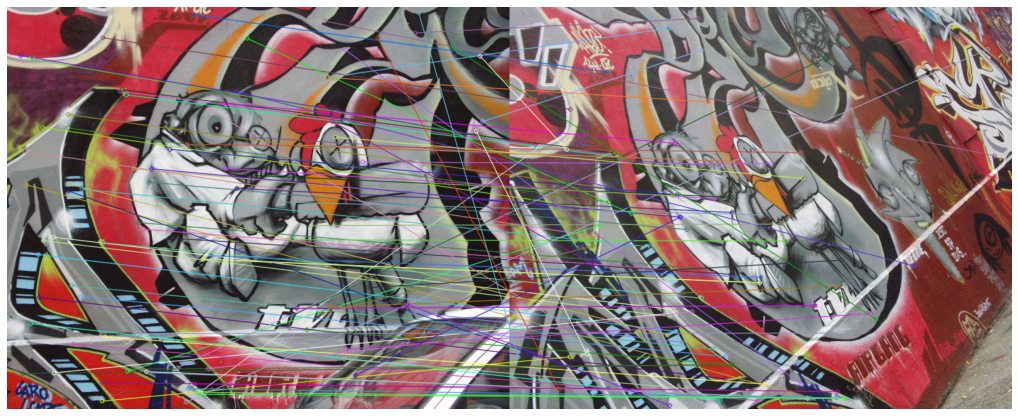

In [136]:


import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread(r'Assignment-02 Materials\img1.ppm')
img2 = cv.imread(r'Assignment-02 Materials\img4.ppm')

sift = cv.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
good = []
# bf = cv.BFMatcher()
# matches = bf.knnMatch(des1,des2,k=2)

for m,n in matches:
    if m.distance < 0.7*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        good.append([m])

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
print(pts1.shape[0])

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
plt.figure(figsize=(18,12))
plt.imshow(img3)
plt.axis('off')
plt.show()


In [66]:
print(img1.shape)

(640, 800, 3)


In [82]:
randomSample(pts1,pts2,4)

(array([[494.22906494, 478.81726074],
        [366.5581665 , 219.27174377],
        [ 78.9214325 , 342.32183838],
        [311.27337646, 618.51824951]]),
 array([[395.22238159, 493.36557007],
        [392.42749023, 238.04898071],
        [179.61222839, 290.39651489],
        [256.3213501 , 594.2689209 ]]))

In [134]:
def randomSample(points1, points2, n):
    sample = np.random.choice(np.shape(points1)[0],n,replace=False)
    x1 = np.zeros([n,2])
    x2 = np.zeros([n,2])
    for i in range(n):
        x1[i]=points1[sample[i]]
        x2[i]=points2[sample[i]]
    return x1,x2

def calculateHomography(points1,points2):
    A = np.zeros((8,9))
    for i in range(4):
        A[i*2,3:6] = np.append(points1[i],[1])
        A[i*2,6:] = -points2[i,1]*np.append(points1[i],[1])
        A[(i*2)+1,:3] = np.append(points1[i],[1])
        A[(i*2)+1,6:] = -points2[i,0]*np.append(points1[i],[1])
    W = np.matmul(A.T,A)
    val, vec = np.linalg.eig(W)
    min_eig = vec[:,np.argmin(np.absolute(val))]
    H = np.reshape(min_eig,(3,3))
    H = H/H[2,2]
    return H

def h_with_RANSAC(its,point_set1,point_set2,T):
    max_inliers=0
    for k in range(its):
        p1,p2 = randomSample(point_set1, point_set2, 4)
        H = calculateHomography(p1,p2)
        no,a1,a2 = siftInlierCount(point_set1,point_set2,H,T)
        if no > max_inliers:
            max_inliers = no
            bestH = H
            ar1,ar2,pp1,pp2 = a1, a2,p1,p2
    return max_inliers, bestH, ar1, ar2,pp1,pp2



In [137]:
# maxIn=0
# for k in range(40000):
#     # sample = random.sample(range(1, np.shape(pts1)[0]), 4)
#     sample = np.random.choice(np.shape(pts1)[0],4,replace='False')
#     # print(sample)
#     x1 = np.zeros([4,2])
#     x2 = np.zeros([4,2])
#     for i in range(4):
#         x1[i]=pts1[sample[i]]
#         x2[i]=pts2[sample[i]]

#     A = np.zeros((8,9))

#     for i in range(4):
#         A[i*2,3:6] = np.append(x1[i],[1])
#         A[i*2,6:] = -x2[i,1]*np.append(x1[i],[1])
#         A[(i*2)+1,:3] = np.append(x1[i],[1])
#         A[(i*2)+1,6:] = -x2[i,0]*np.append(x1[i],[1])
#     W=np.matmul(A.T,A)
#     val, vec = np.linalg.eig(W)
#     # print(np.argmin(H))
#     # print(h)
#     ev_corresponding_to_smallest_ev = vec[:,np.argmin(np.absolute(val))]
#     # print(ev_corresponding_to_smallest_ev)
#     g=np.reshape(ev_corresponding_to_smallest_ev,(3,3))
#     d=g[2,2]
#     d=1/d
#     g=g*d
#     # # print(g)
#     # print(min(val))

#     no = siftInlierCount(pts1,pts2,g,3)
#     if no>maxIn:
#         maxIn=no
#         best=g

# print(maxIn)
# print(best)
# print(im1.shape)

m,H,A1,A2,xx,yy = h_with_RANSAC(50000,pts1,pts2,10)


In [138]:
print(m)
# print(A1)

53


In [139]:
query_pts = np.float32(xx)
 
train_pts = np.float32(yy) 
 
matrix, mask = cv.findHomography(query_pts, train_pts, cv.RANSAC,2.0) 
 


In [140]:
matrix

array([[ 6.39700489e-01,  6.30620846e-01, -2.45048665e+01],
       [-1.37567434e-01,  8.70768789e-01,  1.55827008e+02],
       [ 3.93225693e-04, -1.27484283e-04,  1.00000000e+00]])

In [142]:
m1,HH,A1_,A2,xx1,yy1=h_with_RANSAC(30000,A1,A2,1)

In [143]:
print(m1)

31


In [144]:
H

array([[ 6.39700531e-01,  6.30620881e-01, -2.45048748e+01],
       [-1.37567418e-01,  8.70768837e-01,  1.55827003e+02],
       [ 3.93225792e-04, -1.27484254e-04,  1.00000000e+00]])

In [146]:
H_= [[7.6285898e-01 , -2.9922929e-01,   2.2567123e+02],
   [3.3443473e-01 ,  1.0143901e+00 , -7.6999973e+01],
   [3.4663091e-04 , -1.4364524e-05  , 1.0000000e+00]]


In [145]:
q=(np.sum((H_-H)**2))**0.5
q

341.756649505945

In [127]:
HH

array([[ 7.64812945e-01, -2.80517752e-01,  2.24532067e+02],
       [ 3.31850269e-01,  1.04915426e+00, -8.19695964e+01],
       [ 3.40652565e-04,  3.52718539e-05,  1.00000000e+00]])

In [ ]:
warp = cv.warpPerspective(img1, best,(np.shape(img1)[1],np.shape(img1)[0]))
result = cv.addWeighted(img2, 0.5, warp, 0.5, 0)
warp = cv.cvtColor(warp, cv.COLOR_BGR2GRAY)
print(np.shape(warp))
cv.imshow('img',warp)
cv.imshow('img2',img2)

cv.imshow('img5',result)
cv.waitKey(0)
cv.destroyAllWindows()

(640, 800)


In [128]:
def imshowBGR(img,ax):
    ax.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

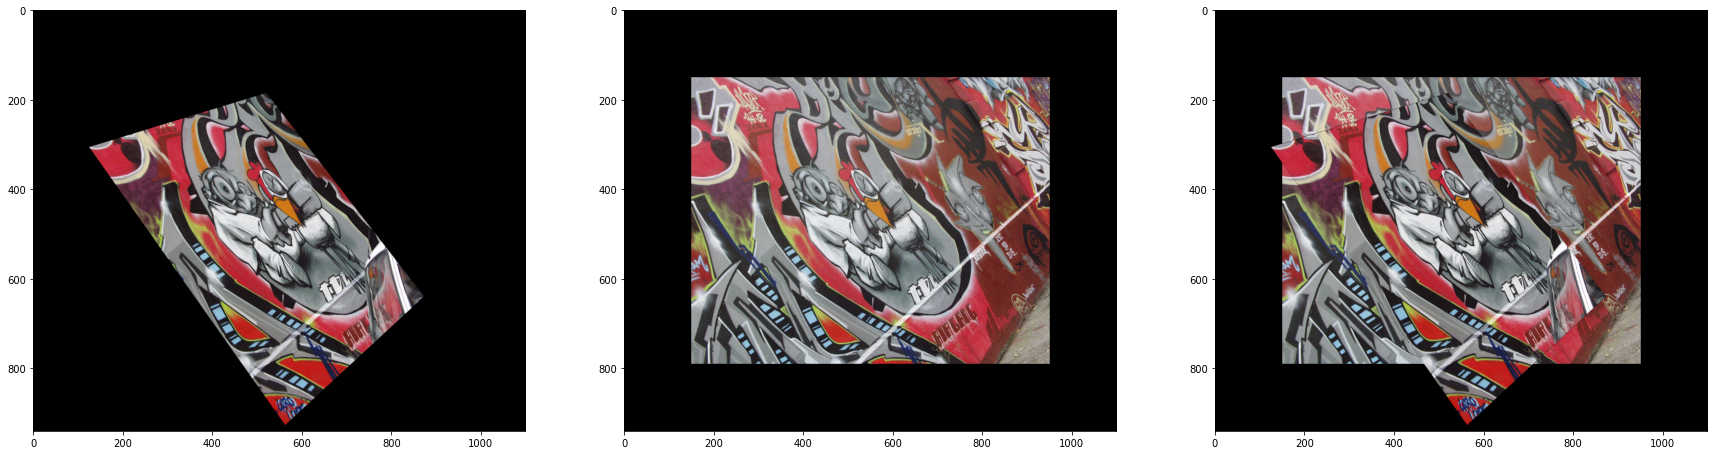

In [149]:
img_canvas=np.zeros((img2.shape[0]+300,img2.shape[1]+300))
Ht=np.array([[1,0,150],[0,1,150],[0,0,1]],dtype=float)

img1_=cv.add(img1,1)
img2_=cv.add(img2,1)


canvas1=cv.warpPerspective(img1_,Ht @ H,img_canvas.shape[1::-1])
canvas2=cv.warpPerspective(img2_,Ht,img_canvas.shape[1::-1])
canvas1_mask=canvas1!=0
canvas_out=np.array(canvas2)
canvas_out[canvas1_mask]=canvas1[canvas1_mask]

fig,ax=plt.subplots(1,3,figsize=(30,20))

imshowBGR(canvas1,ax[0])
imshowBGR(canvas2,ax[1])
imshowBGR(canvas_out,ax[2])